In [1]:
import numpy as np
from scipy import misc
import cv2
import matplotlib.pyplot as plt
import time
import json
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Activation, Input, multiply
from keras.layers.normalization import BatchNormalization
from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam
from keras import backend as Keras

from sklearn import metrics
from scipy.spatial import distance

Using TensorFlow backend.


In [2]:
import os
import sys
# sys.path.append('/Users/tradergllc/github/tensorflow/src/')
sys.path.append('/home/albert/github/tensorflow/src/')
import triplet_merge_cam1
import dense1

### Mine Triplets

In [3]:
CAFFE_ROOT = '/home/albert/github/tensorflow/'
# CAFFE_ROOT = '/Users/tradergllc/github/tensorflow/'
train_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')
test_img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_test')

In [4]:
train_dict = {}
train_files = []
train_labels = []

for f in train_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in train_labels):
            train_labels.append(idt)
            train_dict[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
#         if triplet_merge_cam1.keypoints(path, train=True, keypoint='LHip').max() != 0.0:
        train_files.append([path, idt])
        train_dict[idt].append(path)

train_labels.sort()

In [5]:
test_dict = {}
test_files = []
test_labels = []

for f in test_img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if idt != 0 and idt != -1:
            if not any(idt == l for l in test_labels):
                test_labels.append(idt)
                test_dict[idt] = []
            path = CAFFE_ROOT + 'data/market-1501/bounding_box_test/' + f
#             if triplet_merge_cam1.keypoints(path, train=False, keypoint='LHip').max() != 0.0:
            test_files.append([path, idt])
            test_dict[idt].append(path)
        
test_labels.sort()

### Train Network

In [6]:
train_score = {}
test_score = {}

steps_per_epoch = 100

input_shape = (256,128)

overlay = True
overlay_eval = True
preprocess = True

file_root = 'densenet_triplet_cam_LHip'

In [7]:
if os.path.exists('/home/albert/github/tensorflow/models/%s' % file_root) == False:
    os.system('mkdir /home/albert/github/tensorflow/models/%s' % file_root)

False
False
0.603996038437


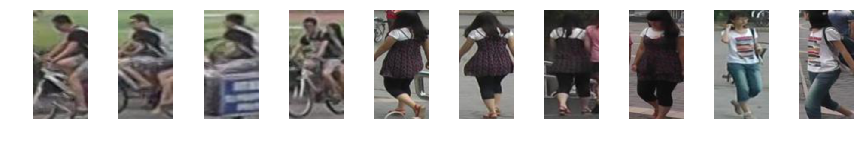

In [8]:
start = time.time()
batch = triplet_merge_cam1.output_batch_generator(train_dict, train_labels,
                                                 overlay=False, preprocess=False,
                                                 shape=input_shape).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0][i].astype(np.uint8))
    plt.axis('off')
plt.show()

In [9]:
start = time.time()
batch_overlay = triplet_merge_cam1.output_batch_generator(train_dict, train_labels,
                                                         overlay=True, preprocess=False,
                                                         shape=input_shape, r=0.35).next()
print time.time() - start

False
True
0.575345993042


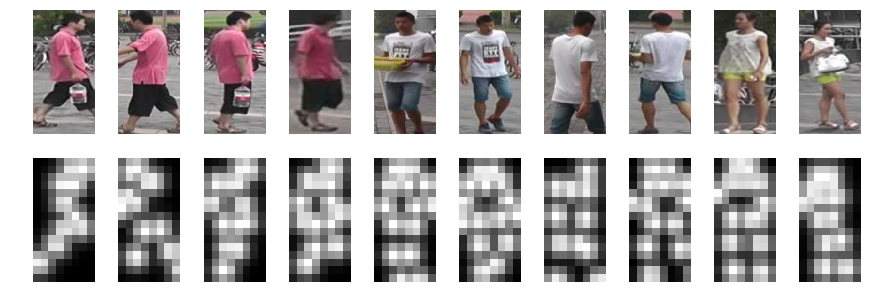

In [10]:
plt.figure(figsize=(15,5))
for i in range(10):
    plt.subplot(2,10,i + 1)
    plt.imshow(batch_overlay[0]['input_1'][i].astype(np.uint8))
    plt.axis('off')
    plt.subplot(2,10,i + 1 + 10)
    plt.imshow(cv2.resize((batch_overlay[0]['input_cam'][i] * 255).astype(np.uint8), (8,16)), cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

In [11]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0003):
    drop = 0.5
    epochs_drop = 10.0
    t1 = 50.0
    if epoch + init_epoch < t1:
        lrate = init_lr
    else:
        lrate = init_lr * np.power(drop,  
               np.floor((epoch + init_epoch - t1 + epochs_drop)/(epochs_drop)))
    return lrate
"""

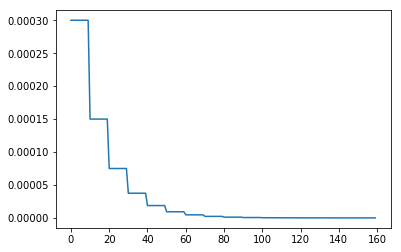

In [12]:
lr = []
for era in range(5,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(160), lr)

In [13]:
def plot_score(score):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    pos_distance = score['pos_distance']
    neg_distance = score['neg_distance']
    bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
    plt.hist(pos_distance, bins, alpha=0.5, label='positive pair')
    plt.hist(neg_distance, bins, alpha=0.5, label='negative pair')
    plt.legend(loc='upper right')

    plt.subplot(1,3,2)
    plt.plot(score['recall'], score['precision'])
    plt.xlabel('recall')
    plt.ylabel('precision')

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
             score['matt_coef'])
    plt.xlabel('dist')
    plt.ylabel('matt_coef')
    
    plt.show()

    print score['rank']

In [14]:
trinet = dense1.DenseNetImageNet121(input_shape=(input_shape[0],input_shape[1],3), cam_placement=[3])
trinet.compile(loss=triplet_merge_cam1.triplet_loss, 
               optimizer=Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

for layer in trinet.layers:
    layer.trainable = True

8 4
Weights for the model were loaded successfully


In [15]:
trinet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 64, 64)   9408        input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 64, 64)   256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128, 64, 64)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [16]:
trinet.load_weights('/home/albert/github/tensorflow/models/densenet_triplet_margin_preprocess/densenet_triplet_margin_preprocess_17000.h5')

In [17]:
history = History()

for era in range(5,16):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    trinet.fit_generator(triplet_merge_cam1.output_batch_generator(train_dict, train_labels, 
                                                        overlay=overlay, preprocess=preprocess, 
                                                        shape=input_shape, keypoint='LHip'), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history])
    
    file_name = file_root + '_' + str(iterations) + '.h5'
    trinet.save_weights('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name))
    
#     train_score[iterations] = triplet_merge_cam1.get_score(trinet, train_dict, train_files, hist=history, 
#                                                           overlay=overlay, train=True, preprocess=preprocess,
#                                                           shape=input_shape)
#     print 'train' , iterations
#     plot_score(train_score[iterations])

#     test_score[iterations] = triplet_merge_cam1.get_score(trinet, test_dict, test_files, hist=history, 
#                                                          overlay=overlay, train=False, preprocess=preprocess,
#                                                          shape=input_shape)
#     print 'test', iterations
#     plot_score(test_score[iterations])

True
True
Epoch 1/10
100/100 [==============================] - 64s - loss: 104.7669    
Epoch 2/10
100/100 [==============================] - 60s - loss: 89.0682    
Epoch 3/10
100/100 [==============================] - 60s - loss: 70.5400    
Epoch 4/10
100/100 [==============================] - 60s - loss: 64.2637    
Epoch 5/10
100/100 [==============================] - 60s - loss: 59.9650    
Epoch 6/10
100/100 [==============================] - 59s - loss: 60.4138    
Epoch 7/10
100/100 [==============================] - 59s - loss: 66.7275    
Epoch 8/10
100/100 [==============================] - 59s - loss: 60.4307    
Epoch 9/10
100/100 [==============================] - 59s - loss: 64.5440    
Epoch 10/10
100/100 [==============================] - 60s - loss: 57.2353    
True
True
Epoch 1/10
100/100 [==============================] - 63s - loss: 43.8399    
Epoch 2/10
100/100 [==============================] - 60s - loss: 38.5030    
Epoch 3/10
100/100 [======================

100/100 [==============================] - 58s - loss: 15.3381    
Epoch 5/10
100/100 [==============================] - 58s - loss: 12.8104    
Epoch 6/10
100/100 [==============================] - 59s - loss: 12.0450    
Epoch 7/10
100/100 [==============================] - 58s - loss: 13.4145    
Epoch 8/10
100/100 [==============================] - 59s - loss: 11.6935    
Epoch 9/10
100/100 [==============================] - 59s - loss: 11.1508    
Epoch 10/10
100/100 [==============================] - 59s - loss: 12.3504    


In [21]:
trinet.load_weights('/home/albert/densenet_triplet_cam_end_neck_10000.h5')

preprocess True
overlay True
overlay_eval False
train True
1000 19.9876840115
2000 39.94500494
3000 59.7792599201
4000 79.5898969173
5000 99.4338078499
6000 119.285142899
7000 139.135115862
8000 158.867327929
9000 178.68569684
10000 198.614285946
11000 218.579842806
12000 238.854975939
train


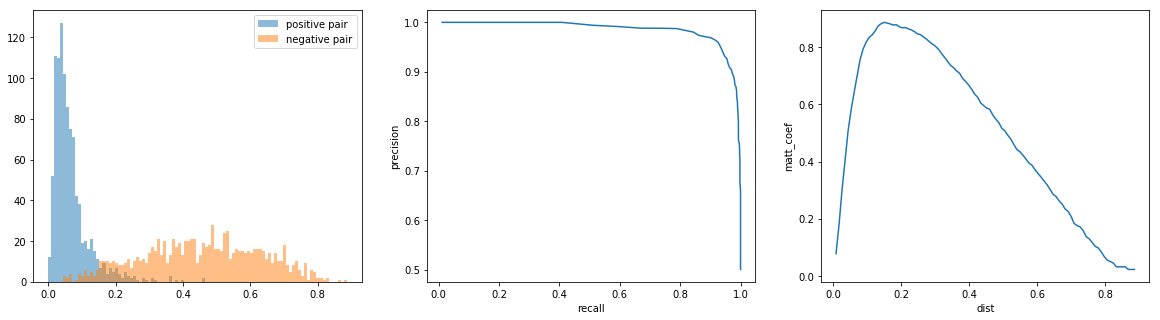

{1: 0.82933333333333337, 20: 0.97633333333333328, 5: 0.93100000000000005}
preprocess True
overlay True
overlay_eval False
train False
1000 19.9774339199
2000 39.863683939
3000 60.1735880375
4000 80.4995031357
5000 100.753204107
6000 121.04123497
7000 141.268768072
8000 161.341048956
9000 181.56111908
10000 201.588022947
11000 221.869103909
12000 242.044095039
13000 262.347460032
test


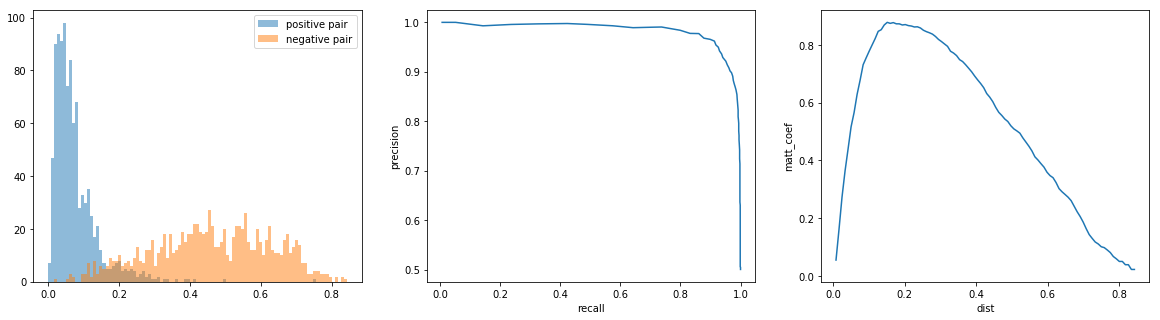

{1: 0.76966666666666672, 20: 0.97033333333333338, 5: 0.91666666666666663}


In [22]:
train_score = triplet_merge_cam1.get_score(trinet, train_dict, train_files, hist=None, 
                                        overlay=True, train=True, preprocess=preprocess, 
                                           shape=input_shape, overlay_eval=False)
print 'train'
plot_score(train_score)

test_score = triplet_merge_cam1.get_score(trinet, test_dict, test_files, hist=None, 
                                    overlay=True, train=False, preprocess=preprocess, 
                                           shape=input_shape, overlay_eval=False)
print 'test'
plot_score(test_score)

In [17]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_score.npz' % (file_root, file_root), train_score)
np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (file_root, file_root), test_score)

### Evaluation

In [ ]:
train_rank1_avg = []
train_rank5_avg = []
train_rank20_avg = []
test_rank1_avg = []
test_rank5_avg = []
test_rank20_avg = []

iterations = 15000

for it in range(1000,iterations + 1000,1000):
    train_rank1_avg.append(np.average(np.array(train_score[it]['rank'][1])))
    train_rank5_avg.append(np.average(np.array(train_score[it]['rank'][5])))
    train_rank20_avg.append(np.average(np.array(train_score[it]['rank'][20])))
    test_rank1_avg.append(np.average(np.array(test_score[it]['rank'][1])))
    test_rank5_avg.append(np.average(np.array(test_score[it]['rank'][5])))
    test_rank20_avg.append(np.average(np.array(test_score[it]['rank'][20])))

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(1000,iterations+1000,1000), train_rank1_avg, label='train_rank1_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank5_avg, label='train_rank5_avg', )
plt.plot(np.arange(1000,iterations+1000,1000), train_rank20_avg, label='train_rank20_avg')

plt.plot(np.arange(1000,iterations+1000,1000), test_rank1_avg, label='test_rank1_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank5_avg, label='test_rank5_avg', linestyle='--')
plt.plot(np.arange(1000,iterations+1000,1000), test_rank20_avg, label='test_rank20_avg', linestyle='--')
plt.legend(loc='lower left')
plt.xlabel('Iteration')
plt.ylabel('Rank')
plt.ylim(0.4,1.0)
plt.show()

In [ ]:
loss = []
for it in range(1000,iterations + 1000,1000):
    loss += train_score[it]['loss']
plt.plot(loss)